In [12]:
import numpy as np
import astropy.units as u
from astropy.io import fits

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.props as props
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina

from importlib import reload

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

from scipy.signal import windows
from scipy.optimize import minimize

wavelength = 650e-9*u.m
pupil_diam = 9.4*u.mm
lyot_stop_diam = 8.6*u.mm
scc_sep = 5.5*u.mm
Nacts = 34

crad = 34/2 * 9.4/10.2 * 8.6/9.4

# Establish the forward model parameters.

Oversampling > 2x suggested for reliable results in Fresnel propagation.


916


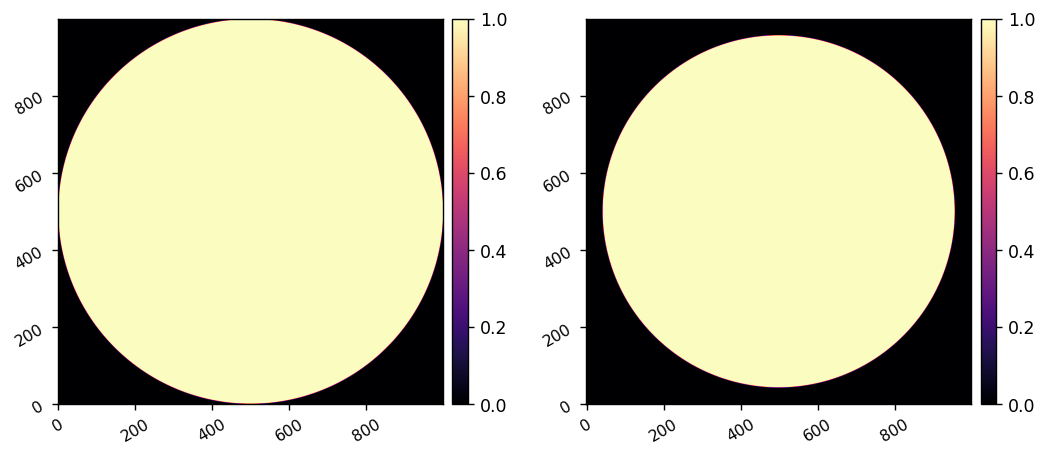

Oversampling > 2x suggested for reliable results in Fresnel propagation.


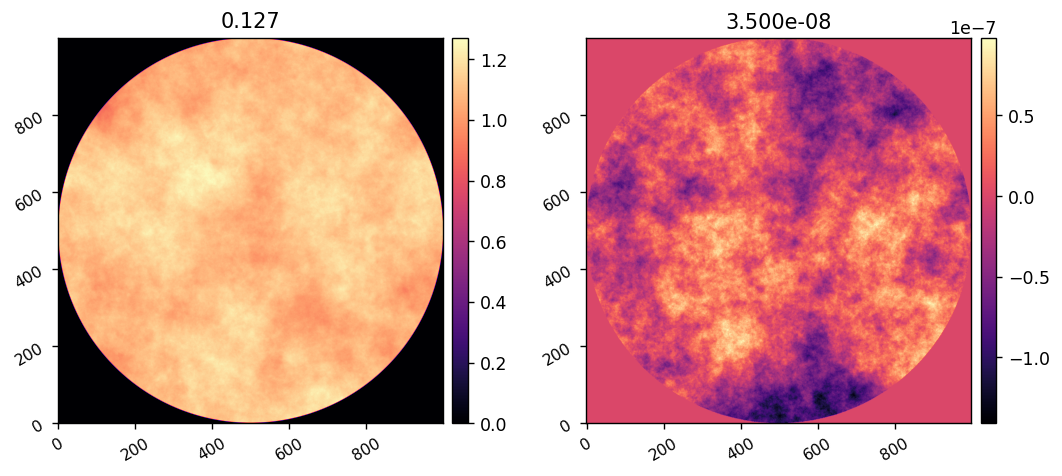

In [7]:
npix = 1000
oversample = 2.048
N = int(npix*oversample)

nlyot = int(np.ceil(lyot_stop_diam/pupil_diam * npix))
if nlyot%2==1:
    nlyot += 1
print(nlyot)

import poppy
pwf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=npix, oversample=1) # pupil wavefront
APERTURE = poppy.CircularAperture(radius=pupil_diam/2).get_transmission(pwf)
LYOT = poppy.CircularAperture(radius=lyot_stop_diam/2).get_transmission(pwf)
imshow2(APERTURE, LYOT)

reload(utils)
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

### Initialize DM parameters

31.914893617021274
1148


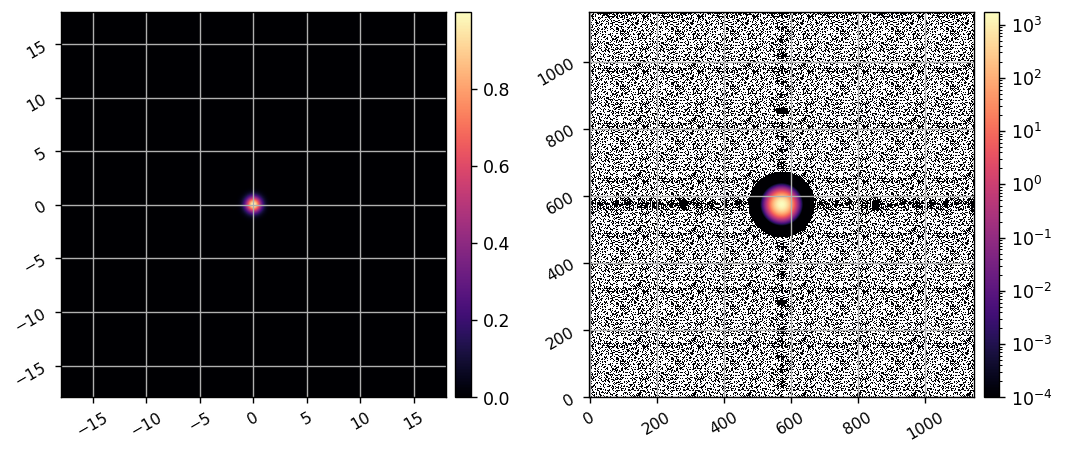

952


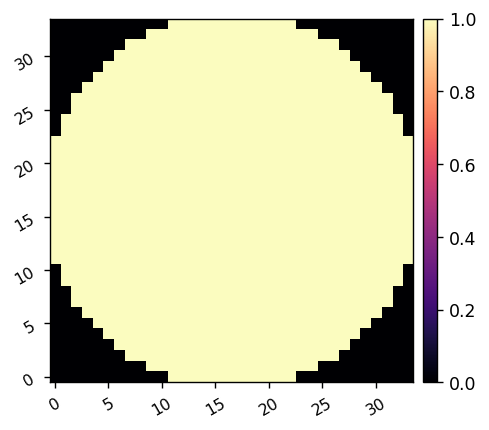

In [8]:
Nact = 34
act_spacing = 0.3*u.mm
inf_sampling = (npix/pupil_diam * act_spacing).value
print(inf_sampling)

reload(ad_scoob)
inf_fun = ad_scoob.make_gaussian_inf_fun(act_spacing=act_spacing, sampling=inf_sampling, 
                                         Nacts_per_inf=Nact + 2, # number of influence functions across the grid
                                         coupling=0.15,)

Nsurf = inf_fun.shape[0]
print(Nsurf)

fourier_inf_fun = xp.fft.fft2(inf_fun)
imshow2(inf_fun, xp.abs(xp.fft.fftshift(fourier_inf_fun)), pxscl1=1/inf_sampling, grid=True, lognorm2=True, vmin2=1e-4)

# DM command coordinates
xc = inf_sampling*(xp.linspace(-Nact//2, Nact//2-1, Nact) + 1/2)
yc = inf_sampling*(xp.linspace(-Nact//2, Nact//2-1, Nact) + 1/2)

dm_mask = xp.ones((Nact,Nact), dtype=bool)
xx = (xp.linspace(-Nact//2, Nact//2 - 1, Nact) + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>(Nact/2 + 1/2)] = 0
Nacts = int(xp.sum(dm_mask))
print(Nacts)
imshow1(dm_mask)

# Influence function frequncy sampling
fx = xp.fft.fftfreq(Nsurf)
fy = xp.fft.fftfreq(Nsurf)

# forward DM model MFT matrices
Mx_dm = xp.exp(-1j*2*np.pi*xp.outer(fx,xc))
My_dm = xp.exp(-1j*2*np.pi*xp.outer(yc,fy))

Mx_dm_back = xp.exp(1j*2*np.pi*xp.outer(xc,fx))
My_dm_back = xp.exp(1j*2*np.pi*xp.outer(fy,yc))

### Initialize vortex mask parameters.

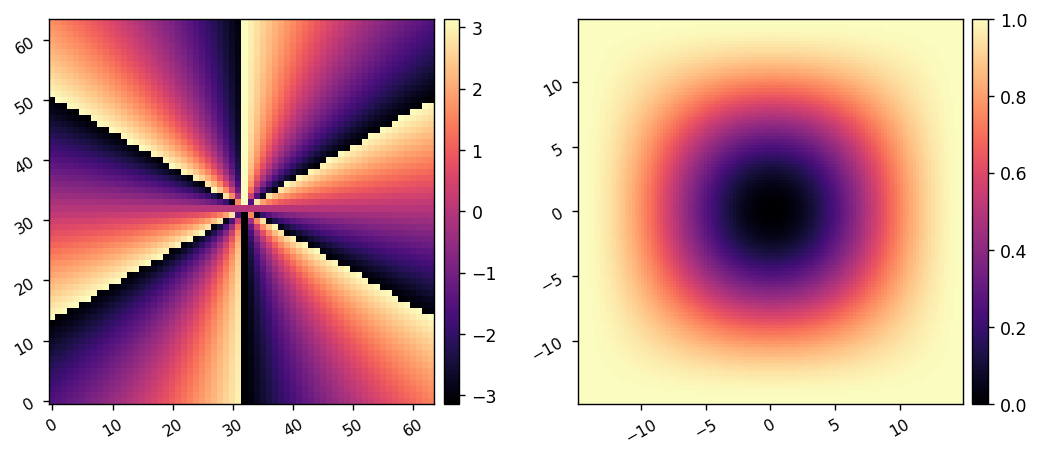

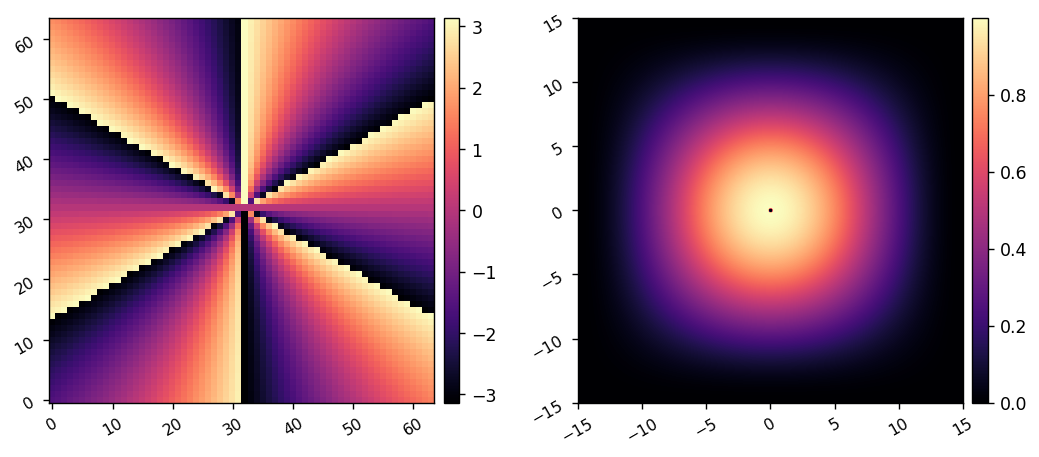

In [9]:
oversample_vortex = 4.096
N_vortex_lres = int(npix*oversample_vortex)
lres_sampling = 1/oversample_vortex # low resolution sampling in lam/D per pixel
lres_win_size = int(30/lres_sampling)
w1d = xp.array(windows.tukey(lres_win_size, 1, False))
lres_window = 1 - utils.pad_or_crop(xp.outer(w1d, w1d), N_vortex_lres)
vortex_lres = props.make_vortex_phase_mask(N_vortex_lres)
imshow2(xp.angle(vortex_lres), lres_window, npix1=64, npix2=lres_win_size, pxscl2=lres_sampling)

hres_sampling = 0.025 # lam/D per pixel; this value is chosen empirically
N_vortex_hres = int(np.round(30/hres_sampling))
hres_win_size = int(30/hres_sampling)
w1d = xp.array(windows.tukey(hres_win_size, 1, False))
hres_window = utils.pad_or_crop(xp.outer(w1d, w1d), N_vortex_hres)
vortex_hres = props.make_vortex_phase_mask(N_vortex_hres)

x = (xp.linspace(-N_vortex_hres//2, N_vortex_hres//2-1, N_vortex_hres)) * hres_sampling
x,y = xp.meshgrid(x,x)
r = xp.sqrt(x**2 + y**2)
sing_mask = r>0.15
hres_window *= sing_mask
imshow2(xp.angle(vortex_hres), hres_window, npix1=64, npix2=hres_win_size, pxscl2=hres_sampling)

psf_pixelscale_lamD = 0.17
npsf = 200

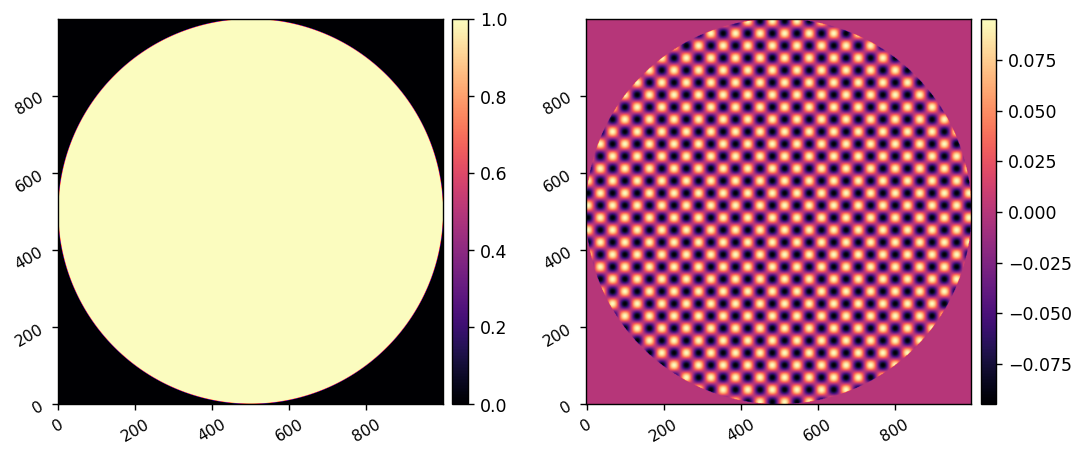

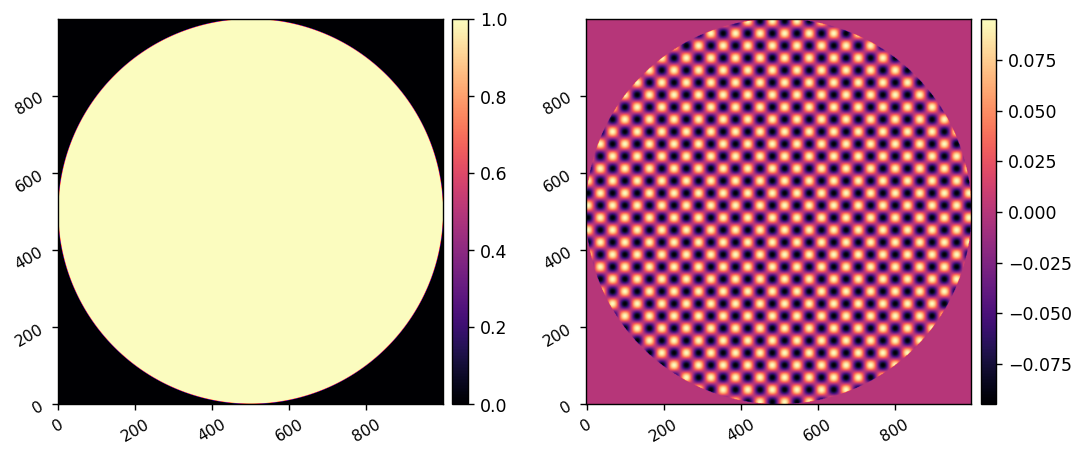

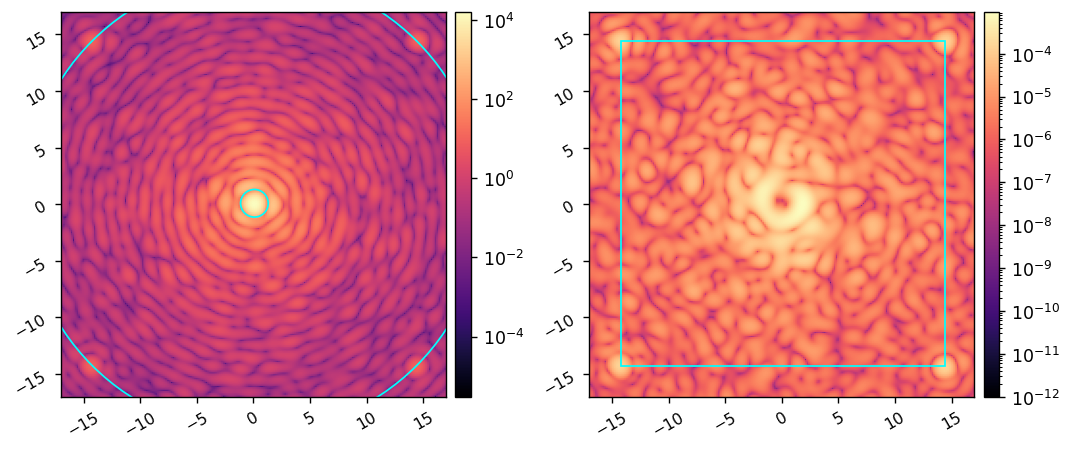

In [14]:
def forward_model(actuators, use_vortex=True, use_wfe=True):
    actuators = xp.array(actuators)
    command = xp.zeros((Nact,Nact))
    command[dm_mask] = actuators
    mft_command = Mx_dm@command@My_dm
    fourier_surf = fourier_inf_fun * mft_command
    dm_surf = xp.fft.ifft2(fourier_surf).real

    dm_phasor = xp.exp(1j * 4*xp.pi/wavelength.to_value(u.m) * dm_surf)
    wf = utils.pad_or_crop(APERTURE, N).astype(xp.complex128)
    
    wf *= utils.pad_or_crop(dm_phasor, N)
    imshow2(xp.abs(wf), xp.angle(wf), npix=npix)

    if use_wfe: 
        wf *= utils.pad_or_crop(WFE, N)
        # imshow2(xp.abs(wf), xp.angle(wf), npix=npix)

    if use_vortex:
        lres_wf = utils.pad_or_crop(wf, N_vortex_lres) # pad to the larger array for the low res propagation
        fp_wf_lres = xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(lres_wf))) # to FPM
        fp_wf_lres *= vortex_lres * lres_window # apply low res (windowed) FPM
        pupil_wf_lres = xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(fp_wf_lres))) # to Lyot Pupil
        pupil_wf_lres = utils.pad_or_crop(pupil_wf_lres, N)

        hres_wf = utils.pad_or_crop(wf, npix) # crop to the pupil diameter for the high res propagation
        fp_wf_hres = props.mft_forward(hres_wf, hres_sampling, N_vortex_hres)
        fp_wf_hres *= vortex_hres * hres_window # apply high res (windowed) FPM
        pupil_wf_hres = props.mft_reverse(fp_wf_hres, hres_sampling, npix,)
        pupil_wf_hres = utils.pad_or_crop(pupil_wf_hres, N)

        wf = (pupil_wf_lres + pupil_wf_hres)/2
        # imshow2(xp.abs(wf), xp.angle(wf), npix=2*npix)

    wf *= utils.pad_or_crop(LYOT, N)
    # imshow2(xp.abs(wf), xp.angle(wf), npix=2*npix)

    wf = utils.pad_or_crop(wf, nlyot)
    fpwf = props.mft_forward(wf, psf_pixelscale_lamD, npsf)

    return fpwf

acts = np.zeros(Nacts)

waffle_command = 10e-9 * xp.ones((Nact,Nact))
waffle_command[1::2, ::2] *= -1
waffle_command[::2, 1::2] *= -1
acts = ensure_np_array(waffle_command[dm_mask]) 

# waffle_command = 10e-9 * xp.ones((Nact,Nact))
# waffle_command[::2,::2] *= -1
# waffle_command[1::2, 1::2] = 0
# acts = ensure_np_array(waffle_command[dm_mask]) 

psf_wf = forward_model(acts, use_vortex=False)
coro_wf = forward_model(acts)

psf = xp.abs(psf_wf)**2
coro_im = xp.abs(coro_wf)**2
imshow2(psf, coro_im/xp.max(psf), 
        pxscl=psf_pixelscale_lamD, 
        patches1=[Circle((psf_pixelscale_lamD/2,psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((psf_pixelscale_lamD/2,psf_pixelscale_lamD/2), np.sqrt(2)*14.33, fill=False, color='cyan')],
        patches2=[Rectangle((-crad+psf_pixelscale_lamD/2, -crad+psf_pixelscale_lamD/2), crad*2, crad*2, fill=False, color='cyan', )],
        lognorm=True, vmin2=1e-12)


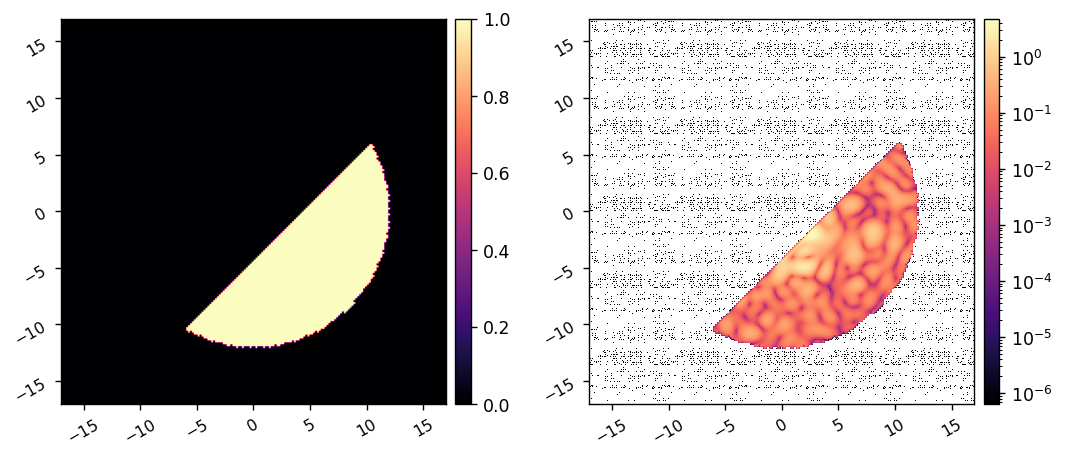

In [19]:
reload(lina.utils)
# control_mask = lina.utils.create_annular_focal_plane_mask(model, 3, 12, 3, rotation=45)
iwa = 3
owa = 12
edge = 3
rotation = 45

x = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*psf_pixelscale_lamD
x,y = xp.meshgrid(x,x)
r = xp.hypot(x, y)
control_mask = (r < owa) * (r > iwa)
if edge is not None: control_mask *= (x > edge)

control_mask = _scipy.ndimage.rotate(control_mask, rotation, reshape=False, order=0)
imshow2(control_mask, coro_im*control_mask, lognorm2=True, pxscl=psf_pixelscale_lamD)


In [23]:
coro_wf[control_mask].dot(coro_wf[control_mask].conjugate()).real

array(915.68332633)

# Create the adjoint model to back propagate 

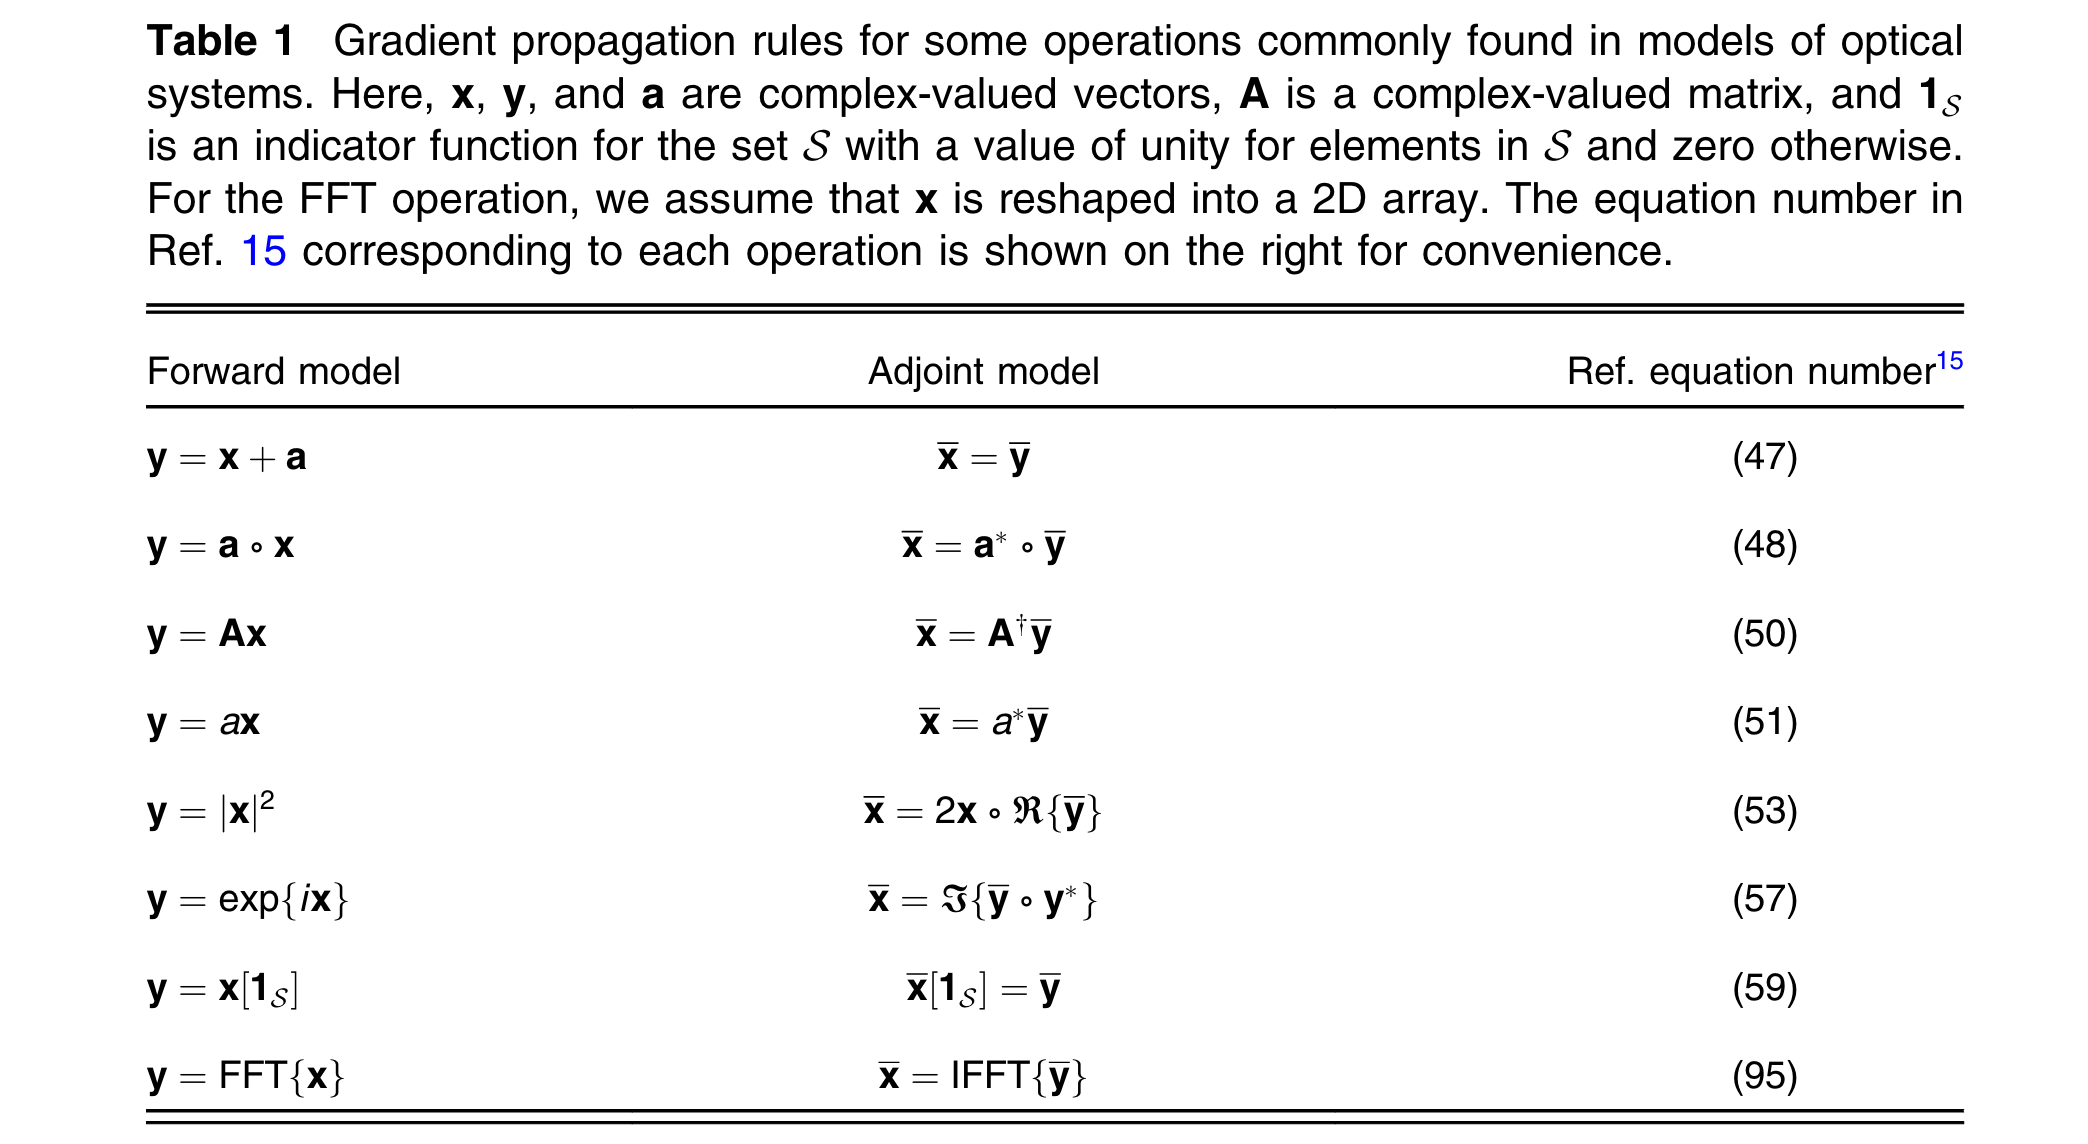

In [ ]:
def compute_cost_fun(actuators, E_ab, E_target=0, r_cond=1e-3):
    # Compute E_dm using the forward DM model 
    E_dm = forward_model(actuators)[control_mask] # make sure to do the array indexing

    # I think if I am using WFE, then I need to do two forwad model propagations
    # E_no_dm = forward_model(np.zeros(Nacts), use_wfe=True)
    # E_total = forward_model(actuators, use_wfe=True)
    # E_dm = E_total - E_no_dm

    delE = E_ab + E_dm
    J_c = M_tik.dot(actuators) # how do I construct M_tik?
    J = delE.dot(delE.conjugate())  +  J_c.dot(J_c)

    return ensure_np_array(J)

actuators = xp.zeros(Nacts)
J0 = compute_cost_fun(actuators)
print(J0)

In [ ]:
def val_and_grad(actuators):
    actuators = xp.array(actuators)
    s_dm = forward_dm(actuators)
    total = wfe_opd + s_dm
    J = total[mask].dot(total[mask]) / 2.4195587499999994e-10

    dJ_dsDM = 2 * (total) / 2.4195587499999994e-10

    x2_bar = xp.fft.fft2(dJ_dsDM)
    x1_bar = fourier_inf_fun.conjugate() * x2_bar
    dJ_dA = Mx_back@x1_bar@My_back
    dJ_dA = dJ_dA[dm_mask].real

    return ensure_np_array(J), ensure_np_array(dJ_dA)

actuators = xp.zeros(Nacts)
J0, dJ_dA = val_and_grad(actuators)
print(J0)
print(dJ_dA.shape)

dm_grad = xp.zeros((Nact,Nact), dtype=dJ_dA.dtype)
dm_grad[dm_mask] = dJ_dA
imshow1(dm_grad)